In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import simweights
import pickle
import os, sys
import re
import numpy as np

from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

import matplotlib as mat
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import pandas as pd
import tables
import h5py
import math
from scipy.stats import mstats
import matplotlib as mpl
import matplotlib.font_manager as font_manager


In [3]:
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing/notebooks/weighting")
from weights import *
from utils import *
from selections import selection_mask
from fonts import *
from plot_utils import *

In [4]:
# Append the custom module path
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing")

# Import the datasets module
from datasets import datasets_snowstorm_test_crystal_density_high as datasets_high

# set the inputs
# reco_versions =  ["snowstorm_iceprod_test_crystal_density_high_level2", "snowstorm_iceprod_test_crystal_density_high_level3casc", "snowstorm_iceprod_test_crystal_density_high_level3muon", "snowstorm_iceprod_test_crystal_density_high_HESE"]
reco_versions =  ["snowstorm_iceprod_test_crystal_density_high_level2", "snowstorm_iceprod_test_crystal_density_high_level3casc", "snowstorm_iceprod_test_crystal_density_high_HESE"]
reco_versions  += ["evtgen_v4_rec_v9"]

# Dynamically select the desired dataset
simulation_datasets = {}
for reco_version in reco_versions: simulation_datasets[reco_version] = getattr(datasets_high, reco_version)

from datasets import datasets_snowstorm_test_crystal_density_low as datasets_low

# reco_versions =  ["snowstorm_iceprod_test_crystal_density_low_level2", "snowstorm_iceprod_test_crystal_density_low_level3casc", "snowstorm_iceprod_test_crystal_density_low_level3muon", "snowstorm_iceprod_test_crystal_density_low_HESE"]
reco_versions =  ["snowstorm_iceprod_test_crystal_density_low_level2", "snowstorm_iceprod_test_crystal_density_low_level3casc", "snowstorm_iceprod_test_crystal_density_low_HESE"]
for reco_version in reco_versions: simulation_datasets[reco_version] = getattr(datasets_low, reco_version)


In [5]:
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year

In [6]:
plotting_path = f"/data/user/tvaneede/GlobalFit/reco_processing/notebooks/benchmark_snowstorm_iceprod/study_anisotropy_test_crystal_density"
os.system(f"mkdir -p {plotting_path}")

0

In [7]:
# weight functions
gamma_astro = 2.87
per_flavor_norm = 2.12
AstroFluxModel_HESE = create_AstroFluxModel(per_flavor_norm=per_flavor_norm, gamma_astro=gamma_astro)

gamma_astro = 2.53
per_flavor_norm = 1.66
AstroFluxModel_cascade = create_AstroFluxModel(per_flavor_norm=per_flavor_norm, gamma_astro=gamma_astro)

In [8]:
def open_datasets( simulation_dataset, keys_to_merge ):

    # open the files
    for key in simulation_dataset:
        print(f"----- Extracting files for {key}")
        simulation_dataset[key]['hdf_file'] = pd.HDFStore(simulation_dataset[key]['hdf_file_path'],'r')
        simulation_dataset[key]['weighter'] = simweights.NuGenWeighter( simulation_dataset[key]['hdf_file'] ,nfiles=simulation_dataset[key]['nfiles'])

    # merging files
    for new_key in keys_to_merge:
        print(f"----- Creating new key {new_key}")
        simulation_dataset[new_key] = {}
        simulation_dataset[new_key]['variables'] = {}
        simulation_dataset[new_key]['weighter'] = None

        for key in keys_to_merge[new_key]:
            
            print(f"Using {key}")
            # merge the weighters
            if simulation_dataset[new_key]['weighter'] == None:
                simulation_dataset[new_key]['weighter'] = simulation_dataset[key]['weighter']
            else: simulation_dataset[new_key]['weighter'] += simulation_dataset[key]['weighter']

    return simulation_dataset



In [9]:
keys_to_merge = {
    "NuTau" : ["NuTau_midE", "NuTau_highE"],
    "NuAll" : ["NuTau"],
}

In [10]:
for key in simulation_datasets: simulation_datasets[key] = open_datasets( simulation_datasets[key], keys_to_merge )

----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Creating new key NuTau
Using NuTau_midE
Using NuTau_highE
----- Creating new key NuAll
Using NuTau
----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Creating new key NuTau
Using NuTau_midE
Using NuTau_highE
----- Creating new key NuAll
Using NuTau
----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Creating new key NuTau
Using NuTau_midE
Using NuTau_highE
----- Creating new key NuAll
Using NuTau
----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Creating new key NuTau
Using NuTau_midE
Using NuTau_highE
----- Creating new key NuAll
Using NuTau
----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Creating new key NuTau
Using NuTau_midE
Using NuTau_highE
----- Creating new key NuAll
Using NuTau
----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Creatin

In [11]:
simulation_datasets.keys()

dict_keys(['snowstorm_iceprod_test_crystal_density_high_level2', 'snowstorm_iceprod_test_crystal_density_high_level3casc', 'snowstorm_iceprod_test_crystal_density_high_HESE', 'evtgen_v4_rec_v9', 'snowstorm_iceprod_test_crystal_density_low_level2', 'snowstorm_iceprod_test_crystal_density_low_level3casc', 'snowstorm_iceprod_test_crystal_density_low_HESE'])

In [32]:
dataset_label_dict = {
    "evtgen_v4_rec_v9" : "HESE baseline",

    "snowstorm_iceprod_test_crystal_density_low_level2" : "level2 scaling 0.8-0.9",
    "snowstorm_iceprod_test_crystal_density_low_level3casc" : "level3casc scaling 0.8-0.9",
    "snowstorm_iceprod_test_crystal_density_low_HESE" : "HESE scaling 0.8-0.9",

    "snowstorm_iceprod_test_crystal_density_high_level2" : "level2 scaling 1.1-1.2",
    "snowstorm_iceprod_test_crystal_density_high_level3casc" : "level3casc scaling 1.1-1.2",
    "snowstorm_iceprod_test_crystal_density_high_HESE" : "HESE scaling 1.1-1.2",
}

check if merging works now, seems to be fine

In [33]:
data = {}

for key in simulation_datasets:

    simulation_dataset = simulation_datasets[key]

    channel_data = {}

    # for flavor in ['NuE', "NuMu", "NuTau"]:
    for flavor in ["NuTau"]:
        if "HESE" in key or "evtgen_v4_rec_v9" in key:
            weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel_HESE) * livetime_s
        else:
            weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel_cascade) * livetime_s
        rate = np.sum(weights)
        error = np.sqrt(np.sum(weights**2))
        channel_data[f"astro_{flavor}"] = f"{rate:.2f} ± {error:.2f}"

    # Conventional
    flavor = "NuAll"
    weights_conv = simulation_dataset[flavor]["weighter"].get_weights(generator_conv) * livetime_s
    rate_conv = np.sum(weights_conv)
    err_conv = np.sqrt(np.sum(weights_conv**2))
    channel_data["conv"] = f"{rate_conv:.3f} ± {err_conv:.3f}"

    # Prompt
    weights_prompt = simulation_dataset[flavor]["weighter"].get_weights(generator_pr) * livetime_s
    rate_prompt = np.sum(weights_prompt)
    err_prompt = np.sqrt(np.sum(weights_prompt**2))
    channel_data["prompt"] = f"{rate_prompt:.2f} ± {err_prompt:.2f}"

    data[ dataset_label_dict[key] ] = channel_data

# Create DataFrame
df = pd.DataFrame.from_dict(data, orient='index')

# Optional: specify column order
columns_order = [f"astro_{flavor}" for flavor in ['NuTau']] + ["conv", "prompt"]
df = df[columns_order]

# Display as string table
print(df.to_string())

                                astro_NuTau           conv         prompt
level2 scaling 1.1-1.2      2300.81 ± 45.80  0.000 ± 0.000  105.95 ± 2.29
level3casc scaling 1.1-1.2   683.94 ± 24.32  0.000 ± 0.000   31.27 ± 1.22
HESE scaling 1.1-1.2           39.58 ± 6.31  0.000 ± 0.000    0.94 ± 0.16
HESE baseline                  35.03 ± 0.40  0.000 ± 0.000    0.80 ± 0.01
level2 scaling 0.8-0.9      2283.58 ± 45.48  0.000 ± 0.000  104.99 ± 2.27
level3casc scaling 0.8-0.9   663.84 ± 23.98  0.000 ± 0.000   30.29 ± 1.20
HESE scaling 0.8-0.9           39.96 ± 6.32  0.000 ± 0.000    0.95 ± 0.16


In [45]:
def compare_dataset_flavor_single( base_key="snowstorm_iceprod_test_crystal_density_low_level2",
                                    alt_key="snowstorm_iceprod_test_crystal_density_high_level2",
                                    var_key1="I3MCWeightDict",
                                    var_key2="PrimaryNeutrinoEnergy",
                                    variable_name="PrimaryNeutrinoEnergy [GeV]",
                                    bins=np.geomspace(1e4, 1e6, 20),
                                    xscale="log",
                                    yscale="log" ):
    
    """Compare one variable (e.g., energy) between two datasets for NuTau."""

    flavor = "NuTau"

    # Compute bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Create figure with two vertically stacked panels
    fig = plt.figure(figsize=(8, 8))
    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)

    ax = fig.add_subplot(gs[0])
    ax_ratio = fig.add_subplot(gs[1], sharex=ax)

    fig.suptitle(rf"{flavor} astro, $\gamma = 2.87$, $\phi_0=2.12$, HESE", fontsize=14)

    # Axis scaling and labels
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_ylabel(f"Rate / {livetime_yr} yr")

    ax_ratio.set_xscale(xscale)
    ax_ratio.set_ylabel("Ratio alt / base")
    ax_ratio.set_xlabel(variable_name)
    ax_ratio.axhline(1, color="gray", linestyle="--", linewidth=1)

    # Extract variables and weights from both datasets
    var_base = simulation_datasets[base_key][flavor]["weighter"].get_column(var_key1, var_key2)
    weights_base = simulation_datasets[base_key][flavor]["weighter"].get_weights(AstroFluxModel_HESE) * livetime_s

    var_alt = simulation_datasets[alt_key][flavor]["weighter"].get_column(var_key1, var_key2)
    weights_alt = simulation_datasets[alt_key][flavor]["weighter"].get_weights(AstroFluxModel_HESE) * livetime_s

    # Compute histograms
    hist_base, _ = np.histogram(var_base, weights=weights_base, bins=bins)
    hist_alt, _ = np.histogram(var_alt, weights=weights_alt, bins=bins)

    # Compute statistical errors
    hist_base_error, _ = error_cal(bin_edges=bins, weights=weights_base, data=var_base)
    hist_alt_error, _ = error_cal(bin_edges=bins, weights=weights_alt, data=var_alt)

    # Compute ratio and errors
    ratio = hist_alt / hist_base
    ratio_error = ratio * np.sqrt(
        (hist_base_error / hist_base) ** 2 + (hist_alt_error / hist_alt) ** 2
    )
    ratio_error[~np.isfinite(ratio_error)] = 0

    # --- Plot upper panel: histograms ---
    ax.hist(
        var_base,
        weights=weights_base,
        bins=bins,
        histtype="step",
        color="black",
        linestyle="-",
        label= dataset_label_dict[base_key],
    )
    ax.hist(
        var_alt,
        weights=weights_alt,
        bins=bins,
        histtype="step",
        color="C3",
        linestyle="-",
        label= dataset_label_dict[alt_key],
    )

    ax.errorbar(bin_centers, hist_base, yerr=hist_base_error, color="black", fmt="o", markersize=2, capsize=5)
    ax.errorbar(bin_centers, hist_alt, yerr=hist_alt_error, color="C3", fmt="o", markersize=2, capsize=5)

    # --- Plot lower panel: ratio ---
    ax_ratio.errorbar(bin_centers, ratio, yerr=ratio_error, fmt="o", color="black", markersize=2, capsize=5)
    ax_ratio.plot(bin_centers, ratio, drawstyle="steps-mid", color="black")

    # Layout adjustments
    plt.setp(ax.get_xticklabels(), visible=False)
    ax_ratio.set_ylim(0.0, 2.0)
    ax_ratio.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
    ax.set_xlim(bins[0], bins[-1])
    ax.set_ylim(
        0.5 * np.min([hist_base.min(), hist_alt.min()]),
        2.0 * np.max([hist_base.max(), hist_alt.max()]),
    )
    ax.legend(title="Dataset")

    # Save and show
    plt.savefig(f"{plotting_path}/{var_key1}_{var_key2}_{flavor}_{base_key}_vs_{alt_key}.pdf")
    plt.show()


/tmp/ipykernel_32354/642377538.py:52: RuntimeWarning: invalid value encountered in divide
  ratio = hist_alt / hist_base
/tmp/ipykernel_32354/642377538.py:54: RuntimeWarning: invalid value encountered in divide
  (hist_base_error / hist_base) ** 2 + (hist_alt_error / hist_alt) ** 2
/tmp/ipykernel_32354/642377538.py:90: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(


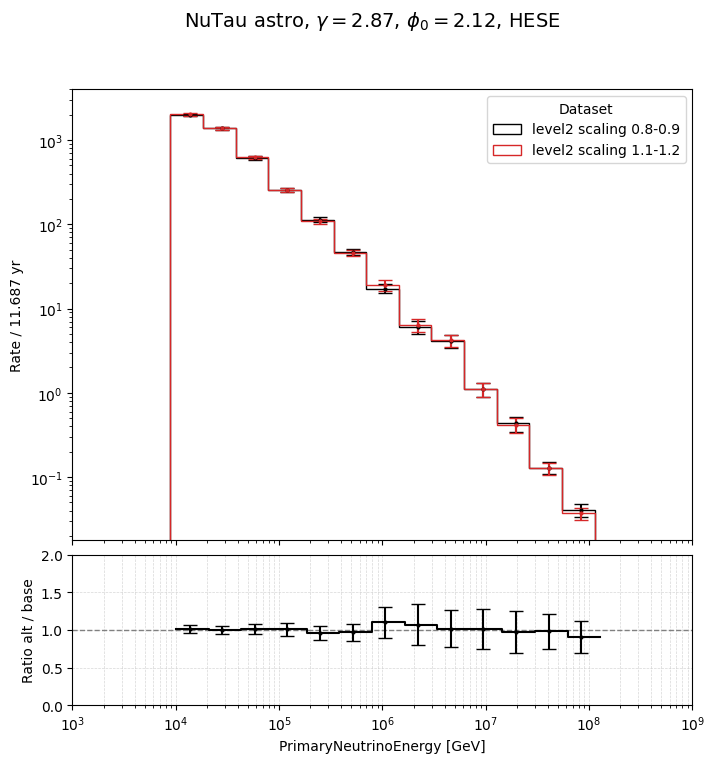

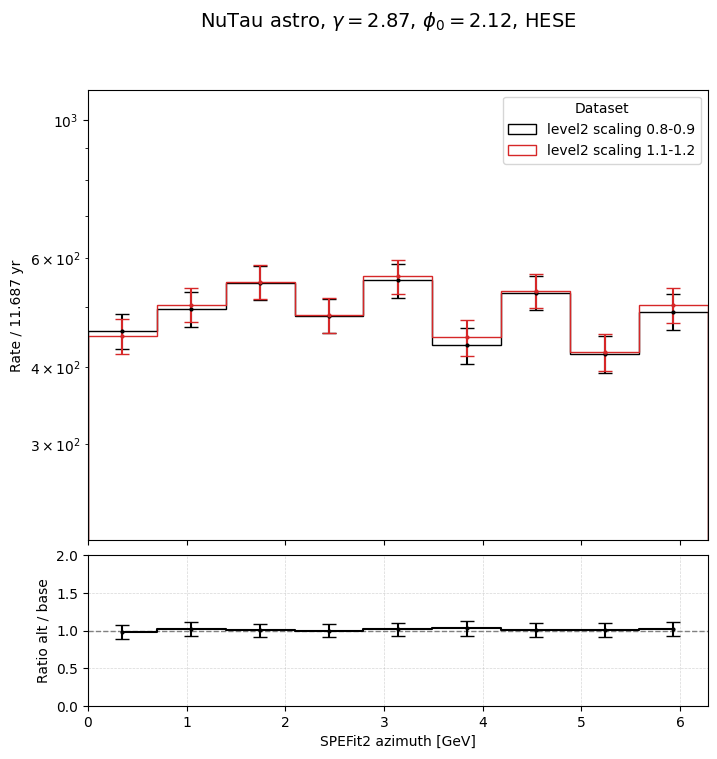

In [46]:
compare_dataset_flavor_single( base_key="snowstorm_iceprod_test_crystal_density_low_level2",
                                alt_key="snowstorm_iceprod_test_crystal_density_high_level2",
                                var_key1="I3MCWeightDict",
                                var_key2="PrimaryNeutrinoEnergy",
                                variable_name="PrimaryNeutrinoEnergy [GeV]",
                                bins=np.geomspace(1e3, 1e9, 20),
                                xscale="log",
                                yscale="log" )

compare_dataset_flavor_single( base_key="snowstorm_iceprod_test_crystal_density_low_level2",
                                alt_key="snowstorm_iceprod_test_crystal_density_high_level2",
                                var_key1 = "I3MCWeightDict", var_key2 = "PrimaryNeutrinoAzimuth",
                                variable_name = "SPEFit2 azimuth [GeV]", bins = np.linspace(0, 2*np.pi, 10), 
                                xscale = "linear", yscale = "log" )

Now for l2
- CascadeLlhVertexFit_L2
- LineFit
- MPEFit
- SPEFit2

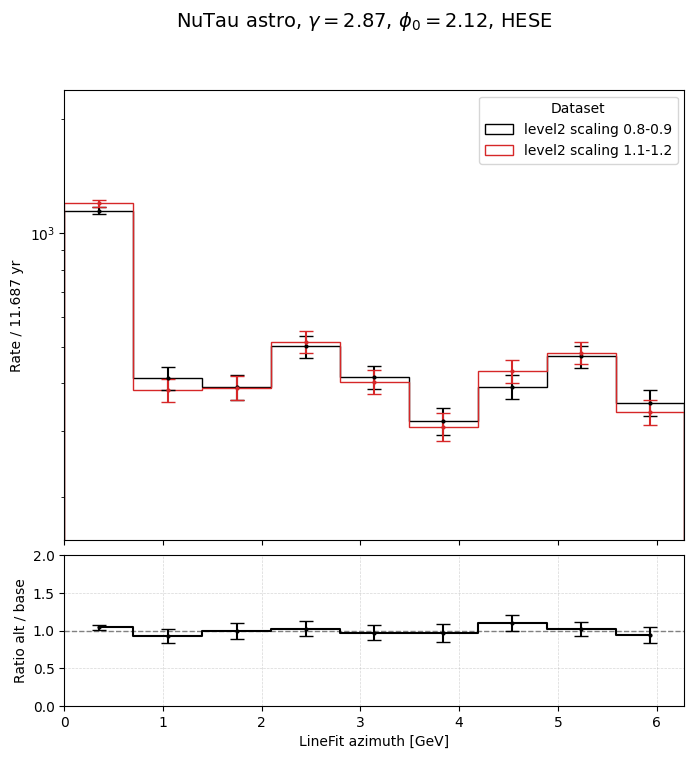

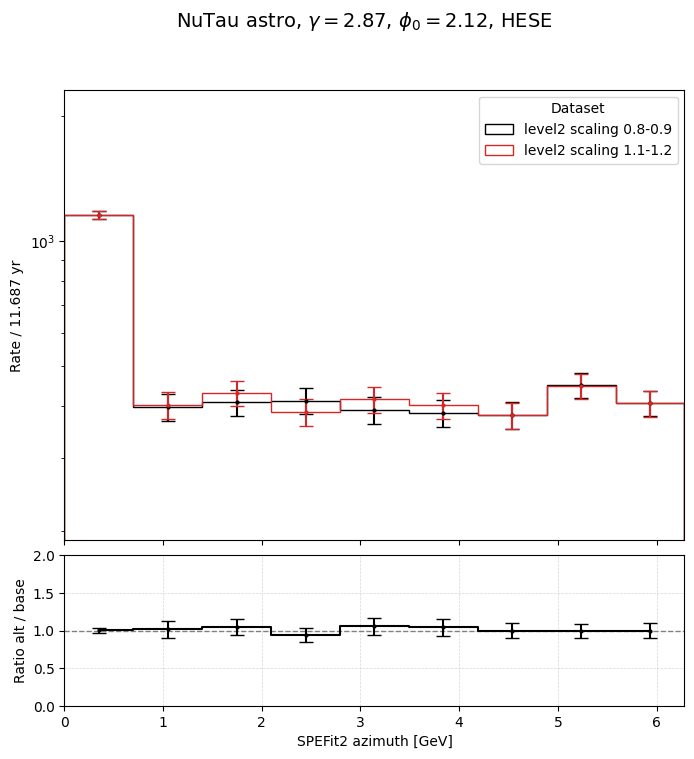

In [48]:
compare_dataset_flavor_single( base_key = "snowstorm_iceprod_test_crystal_density_low_level2", 
                                alt_key = "snowstorm_iceprod_test_crystal_density_high_level2", 
                                var_key1 = "LineFit", var_key2 = "azimuth",
                                variable_name = "LineFit azimuth [GeV]", bins = np.linspace(0, 2*np.pi, 10), 
                                xscale = "linear", yscale = "log" )

compare_dataset_flavor_single( base_key = "snowstorm_iceprod_test_crystal_density_low_level2", 
                                alt_key = "snowstorm_iceprod_test_crystal_density_high_level2", 
                                var_key1 = "SPEFit2", var_key2 = "azimuth",
                                variable_name = "SPEFit2 azimuth [GeV]", bins = np.linspace(0, 2*np.pi, 10), 
                                xscale = "linear", yscale = "log" )


Lets do some reco variables for l3
- CscdL3_CascadeLlhVertexFit
- CscdL3_SPEFit16
- L3_MonopodFit4_AmptFit
- MPEFit
- SPEFit2

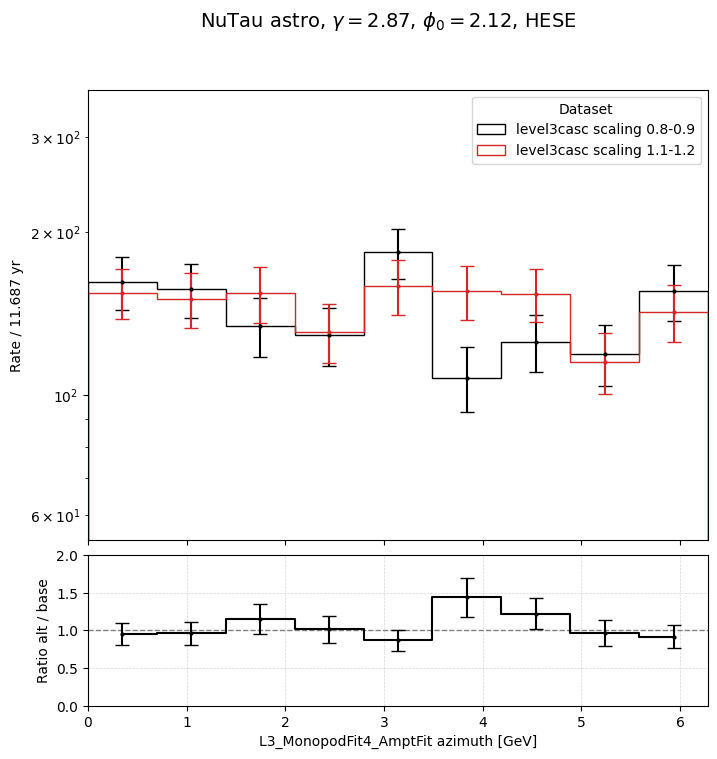

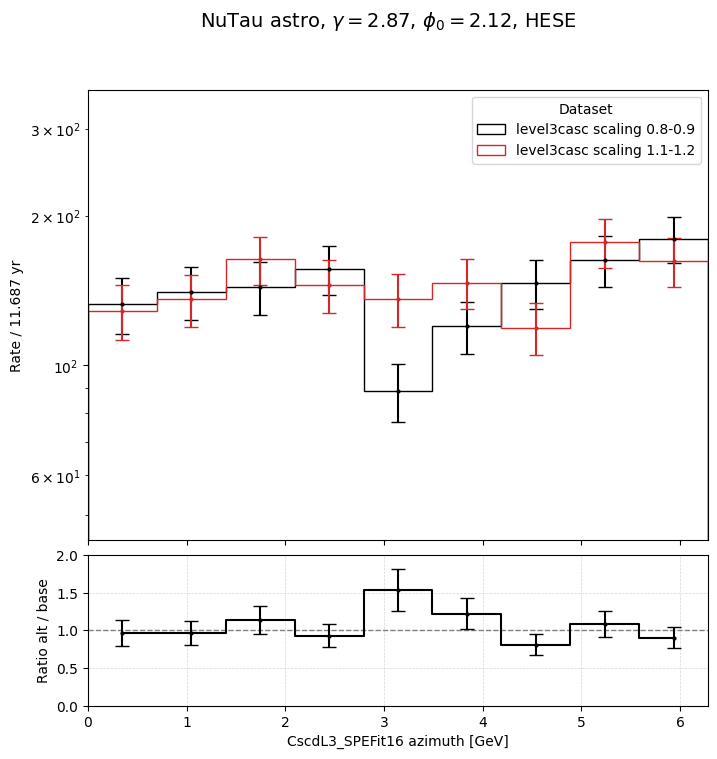

In [50]:
compare_dataset_flavor_single( base_key = "snowstorm_iceprod_test_crystal_density_low_level3casc", 
                                alt_key = "snowstorm_iceprod_test_crystal_density_high_level3casc", 
                                var_key1 = "L3_MonopodFit4_AmptFit", var_key2 = "azimuth",
                                variable_name = "L3_MonopodFit4_AmptFit azimuth [GeV]", bins = np.linspace(0, 2*np.pi, 10), 
                                xscale = "linear", yscale = "log" )

compare_dataset_flavor_single( base_key = "snowstorm_iceprod_test_crystal_density_low_level3casc", 
                                alt_key = "snowstorm_iceprod_test_crystal_density_high_level3casc", 
                                var_key1 = "CscdL3_SPEFit16", var_key2 = "azimuth",
                                variable_name = "CscdL3_SPEFit16 azimuth [GeV]", bins = np.linspace(0, 2*np.pi, 10), 
                                xscale = "linear", yscale = "log" )

HESE
- TaupedeFit_iMIGRAD_PPB0
- MonopodFit_iMIGRAD_PPB0

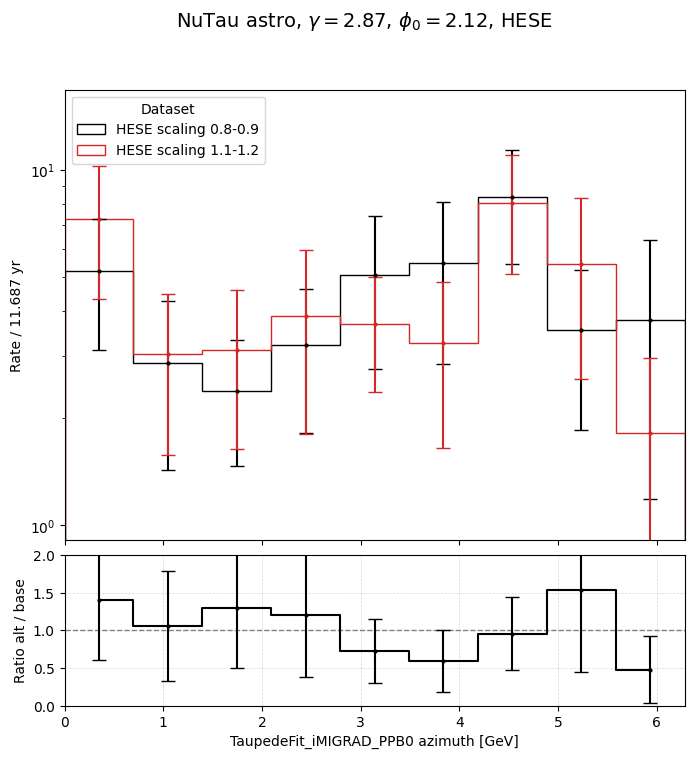

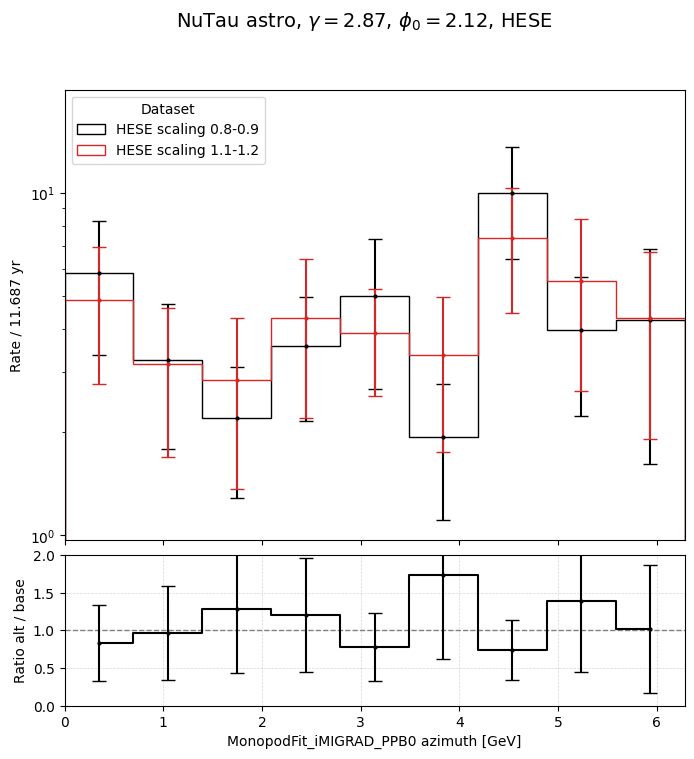

In [51]:
compare_dataset_flavor_single( base_key = "snowstorm_iceprod_test_crystal_density_low_HESE", 
                                alt_key = "snowstorm_iceprod_test_crystal_density_high_HESE", 
                                var_key1 = "TaupedeFit_iMIGRAD_PPB0", var_key2 = "azimuth",
                                variable_name = "TaupedeFit_iMIGRAD_PPB0 azimuth [GeV]", bins = np.linspace(0, 2*np.pi, 10), 
                                xscale = "linear", yscale = "log" )

compare_dataset_flavor_single( base_key = "snowstorm_iceprod_test_crystal_density_low_HESE", 
                                alt_key = "snowstorm_iceprod_test_crystal_density_high_HESE", 
                                var_key1 = "MonopodFit_iMIGRAD_PPB0", var_key2 = "azimuth",
                                variable_name = "MonopodFit_iMIGRAD_PPB0 azimuth [GeV]", bins = np.linspace(0, 2*np.pi, 10), 
                                xscale = "linear", yscale = "log" )